# Header

In [ ]:
import tracemalloc

from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from time import time_ns as now
from tabulate import tabulate
import numpy.linalg as ln
import scipy.optimize as so
from matplotlib.patches import Rectangle


# Задание №1

In [ ]:

def generate_dots_simple(n: int, a: float, b: float, delta=5):
    ch = 10.0 / n
    # print('Line: ', a, 'x+', b, sep='')
    x_values = [ch * i for i in range(1, n + 1)]
    y_values = [a * p + b + random.uniform(-delta, delta) for p in x_values]
    return x_values, y_values


def show_line(a: float, b: float, l=0, r=10, fmt='', label=''):
    line_xs = [l, r]
    plt.plot(line_xs, [a * x + b for x in line_xs], fmt, label=label)
    plt.legend()


def exact_ans(points, draw=False, log=False):
    arr = np.ones((len(points), 2), dtype=float)
    y = np.zeros(len(points))
    for i in range(len(points)):
        arr[i][1] = points[i][0]
        y[i] = points[i][1]
    ans = np.linalg.inv(np.transpose(arr) @ arr) @ np.transpose(arr) @ y
    if draw:
        xs = [p[0] for p in points]
        show_line(ans[1], ans[0], l=min(xs), r=max(xs), fmt='r--', label='Exact')
    if log:
        print('Exact: ', [ans[1], ans[0]])
    return [ans[1], ans[0]]


In [ ]:

class LinearRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

inputDim = 1
outputDim = 1
epochs = 5
dimension = 500

global_batch = 5

model = LinearRegression(inputDim, outputDim)

criterion = torch.nn.MSELoss()

Modifications = [[lambda: torch.optim.SGD(model.parameters(), lr=0.001), "Default SGD"],
                 [lambda: torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), "Momentum"],
                 [lambda: torch.optim.SGD(model.parameters(), lr=0.001, nesterov=True, momentum=0.9), "Nesterov"],
                 [lambda: torch.optim.Adagrad(model.parameters(), lr=10), "Adagrad"],
                 [lambda: torch.optim.RMSprop(model.parameters(), lr=0.1, alpha=0.99), "RMSProp"],
                 [lambda: torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.99), eps=1e-8), "Adam"]]


## Методы из лабораторной №2

In [ ]:

def calc_grad(w, points, batch=global_batch):
    res = np.array([0] * 2, float)
    a = w[0]
    b = w[1]
    n = len(points)
    for i in range(batch):
        ind = (calc_grad.counter * batch + i) % n
        if ind == 0:
            random.shuffle(calc_grad.order)
        x = points[calc_grad.order[ind]][0]
        y = points[calc_grad.order[ind]][1]
        # print(calc_grad.order[ind], res[0], res[1], x, y, a, b)
        res[0] += 2 * a * x * x + 2 * b * x - 2 * x * y
        res[1] += 2 * b + 2 * a * x - 2 * y
    res[0] /= n
    res[1] /= n
    calc_grad.counter += 1
    return res


def linear_regression_extend(points, calc_point, draw=False,
                             log=False, batch=global_batch):
    def _help(points, calc_point, draw, log, batch):
        calc_grad.counter = 0
        # dl, dr = min(points), max(points)
        a = 0
        b = 1
        # print('Start point:', a, b)
        w = np.array([1, 1], float)
        tmp = 2
        descent_points = [w]
        calc_grad.order = [i for i in range(len(points))]
        while calc_grad.counter * batch < epochs * len(points):
            tmp += 2
            w = calc_point(w, points, lambda w, p: calc_grad(w, p, batch))
            descent_points.append(w)
        if draw:
            xs = [point[0] for point in points]
            ys = [point[1] for point in points]
            plt.scatter(xs, ys)
            show_line(w[0], w[1], l=min(xs), r=max(xs), fmt='g', label='SGD')
        if log:
            print('SGD: ', w)
        return [w, descent_points]
    return _help(points, calc_point, draw, log, min(batch, len(points)))


def linear_regression(points, mod, draw=False, log=False, batch=global_batch):
    calc_point = None
    if mod.__name__ == 'Default':
        calc_point = mod(n=len(points), batch=batch)
    else:
        calc_point = mod()
    return linear_regression_extend(points, calc_point, draw, log, batch)[0]


def get_step_lr(count_dots, batch, alpha):
    def help(cur):
        get_step_lr.counter += 1
        if get_step_lr.counter >= get_step_lr.steps:
            get_step_lr.counter = 0
            cur -= get_step_lr.step
        return cur

    get_step_lr.steps = 10
    get_step_lr.step = alpha / (count_dots * epochs) * get_step_lr.steps
    get_step_lr.counter = 0
    return help


def Default(n: int = 100, batch: int = global_batch):
    Default.alpha = 0.01
    func = get_step_lr(n, batch, Default.alpha)

    def _help(w, points, grad):
        Default.alpha = func(Default.alpha)
        return w - Default.alpha * grad(w, points)

    return _help


def Momentum():
    def _help(w, points, grad, alpha=0.001, beta=0.9):
        if Momentum.v is None:
            Momentum.v = -alpha * grad(w, points)
        else:
            Momentum.v = beta * Momentum.v - alpha * grad(w, points)
        return w + Momentum.v
    Momentum.v = None
    return _help


def Nesterov():
    def _help(w, points, grad, alpha=0.01, beta=0.9):
        if Nesterov.v is None:
            Nesterov.v = -alpha * grad(w, points)
        else:
            Nesterov.v = beta * Nesterov.v - alpha * grad(w + beta * Nesterov.v, points)
        return w + Nesterov.v
    Nesterov.v = None
    return _help


def Adagrad(eps=1e-8):
    def _help(w, points, grad, alpha=20):
        g = grad(w, points)
        if Adagrad.G is None:
            Adagrad.G = g * g
        else:
            Adagrad.G += g * g
        return w - alpha / ((Adagrad.G + eps) ** 0.5) * g
    Adagrad.G = None
    return _help


def RMSprop():
    def _help(w, points, grad, alpha=0.1, gamma=0.99, eps=1e-8):
        g = grad(w, points)
        if RMSprop.G is None:
            RMSprop.G = (1 - gamma) * g * g
        else:
            RMSprop.G = gamma * RMSprop.G + (1 - gamma) * g * g
        return w - alpha / ((RMSprop.G + eps) ** 0.5) * g
    RMSprop.G = None
    return _help


def Adam():
    def _help(w, points, grad, alpha=0.1, beta1=0.9, beta2=0.99, eps=1e-8):
        g = grad(w, points)
        Adam.deg += 1
        if Adam.v is None:
            Adam.v = (1 - beta1) * g
        else:
            Adam.v = beta1 * Adam.v + (1 - beta1) * g
        if Adam.G is None:
            Adam.G = (1 - beta2) * g * g
        else:
            Adam.G = beta2 * Adam.G + (1 - beta2) * g * g
        return w - alpha / ((Adam.G + eps) ** 0.5) * (Adam.v / (1 - beta1 ** Adam.deg))
    Adam.v = None
    Adam.G = None
    Adam.deg = 0
    return _help


## Профайлер

In [ ]:

def profile_task(batch=global_batch, draw=False):
    x_values, y_values = generate_dots_simple(dimension, random.uniform(-10, 10), random.uniform(-10, 10))

    x_train = np.array(x_values, dtype=np.float32)
    x_train = x_train.reshape(-1, 1)

    y_train = np.array(y_values, dtype=np.float32)
    y_train = y_train.reshape(-1, 1)
    points = np.concatenate((x_train, y_train), axis=1)
    k, b = exact_ans(points)
    stats = [['method', 'batch', 'probability', 'delta', 'time (ms)', 'peek memory usage (MB)']]
    n = len(x_train)
    delta_min = sum((k * x_train[i] + b - y_train[i]) ** 2 for i in range(n))

    for optimizer_ctor, name in Modifications:
        tracemalloc.start()
        optimizer = optimizer_ctor()
        time = now()
        i = 0
        for epoch in range(epochs):
            i = (i % n)
            while i < n:
                inputs = Variable(torch.from_numpy(x_train[i:i + batch]))
                labels = Variable(torch.from_numpy(y_train[i:i + batch]))

                optimizer.zero_grad()

                outputs = model(inputs)

                loss = criterion(outputs, labels)
                loss.backward()

                optimizer.step()

                i += batch
            # scheduler.step()

        with torch.no_grad():
            predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()

        delta = (sum((predicted[i] - y_train[i]) ** 2 for i in range(n)) - delta_min)/n

        time = now() - time

        if draw:
            plt.clf()
            plt.title(label=name)
            plt.plot(x_train, y_train, 'b.', label='True data', alpha=0.5)
            plt.plot(x_train, predicted, 'g', label='SGD Line', alpha=0.5)
            exact_ans(points, draw=True)
            plt.legend(loc='best')
            plt.show()
        _, peek_mem = tracemalloc.get_traced_memory()
        stats.append([name, batch, 1 if delta < 20 else 0, delta, time/1000/1000, peek_mem/1024/1024])
    return tabulate(stats, headers='firstrow', tablefmt='fancy_grid')

def profile_tasks(test_cnt=20, batch=global_batch):
    tab = profile_task(batch=batch)
    for _ in range(test_cnt - 1):
        tab_tmp = profile_task(batch=batch)
        for i in range(1, len(tab_tmp)):
            for j in range(2, len(tab_tmp[i])):
                tab[i][j] += tab_tmp[i][j]
    for _ in range(test_cnt - 1):
        tab_tmp = profile_task(batch=batch)
        for i in range(1, len(tab_tmp)):
            for j in range(2, len(tab_tmp[i])):
                tab[i][j] += tab_tmp[i][j]
    return tab


print(profile_tasks(test_cnt=1))


╒═════════════╤═════════╤═══════════════╤══════════╤═════════════╤══════════════════════════╕
│ method      │   batch │   probability │    delta │   time (ms) │   peek memory usage (MB) │
╞═════════════╪═════════╪═══════════════╪══════════╪═════════════╪══════════════════════════╡
│ Default SGD │       5 │             1 │ 7.01518  │     343.214 │                0.0380363 │
├─────────────┼─────────┼───────────────┼──────────┼─────────────┼──────────────────────────┤
│ Momentum    │       5 │             1 │ 0.339736 │     270.685 │                0.0444765 │
├─────────────┼─────────┼───────────────┼──────────┼─────────────┼──────────────────────────┤
│ Nesterov    │       5 │             1 │ 0.435026 │     294.411 │                0.053524  │
├─────────────┼─────────┼───────────────┼──────────┼─────────────┼──────────────────────────┤
│ Adagrad     │       5 │             1 │ 0.296312 │     353.023 │                0.144519  │
├─────────────┼─────────┼───────────────┼──────────┼────────

#Задание №2

## Help functions

In [ ]:

def add_eps(pos, x_num, eps):
    poseps = [xi for xi in pos]
    poseps[x_num] += eps
    return np.array(poseps)


def differentiate(fun, x_num, pos, eps=1e-4):
    return (fun(add_eps(pos, x_num, eps)) - fun(pos)) / eps


def differentiate_fun(fun, x_num, eps=1e-4):
    return lambda pos: differentiate(fun, x_num, pos, eps)


def count_grad(r, pos):
    return np.array([differentiate(r, i, pos) for i in range(len(pos))])


def count_hess(fun, pos):
    n = len(pos)
    grad = [differentiate_fun(fun, i) for i in range(n)]
    res = np.array([count_grad(grad[i], pos) for i in range(n)])

    mn = res[0][0]

    for i in range(len(res)):
        mn = min(mn, res[i][i])
    tau = max(-mn, 0.01)

    for i in range(1000):
        try:
            np.linalg.cholesky(res)
            break
        except np.linalg.LinAlgError:
            res += np.diag([tau] * len(res))
            tau *= 2.0
    return res


def count_j(r, pos):
    return np.array([count_grad(ri, pos) for ri in r])


def count_r(r, pos):
    return np.array([ri(pos) for ri in r])


def count_f(rs, pos):
    res = 0
    for i in range(len(rs)):
        res += rs[i](pos) ** 2
    return res


def count_f_fun(rs):
    return lambda pos: count_f(rs, pos)


def gradient_advanced(f, pos, eps=0.01):
    arr = np.array([0] * len(pos), float)
    for i in range(len(pos)):
        pos[i] += eps
        arr[i] = f(pos)
        pos[i] -= 2 * eps
        arr[i] = (arr[i] - f(pos)) / (2 * eps)
        pos[i] += eps
    return arr

## Методы из лабораторной работы №3

### Test block

In [ ]:

class TestCase:
    def __init__(self, n: int, points, rs, start_point):
        self.n = n
        self.points = points
        self.rs = rs
        self.start_point = start_point

    def to_sum(self):
        return lambda x: sum([(r(x) ** 2) for r in self.rs])

    def squares(self):
        return [lambda x: (r(x) ** 2) for r in self.rs]

    def calculate_delta(self, ans):
        return abs(ans - self.to_sum(self.points))

    def __str__(self):
        return str(len(self.points)) + '\n' + ' '.join(map(str, self.start_point)) + '\n' + '\n'.join(map(lambda x: ' '.join(map(str, x)), self.points))


class TestMethod:
    def _generate(f, eps):
        def get_by_point(point):
            return lambda args: (f(point[0], args) - point[1] + eps)
        return lambda points: [get_by_point(i) for i in points]

    # rsp -- recommended start point
    def __init__(self, n: int, name: str, fbase, rsp, left=-10, right=10, eps=1e-7):
        self.n = n
        self.name = name
        self.rsp = rsp
        self.left = left
        self.right = right
        self.fbase = fbase
        self.fun = TestMethod._generate(fbase, eps)

    def substitute_beta_to_fbase(self, beta):
        return lambda x: self.fbase(x, beta)

    def init_by_random_points(self, m=100, eps=1e-2):
        points = [[random.uniform(self.rsp[i] - eps, self.rsp[i] + eps) for i in range(self.n)] for _ in range(m)]
        return TestCase(self.n, points, self.fun(points), self.rsp)

    def generate_along_ansfunction(self, beta, m=100, delta=1):
        tmpfun = lambda x: self.fbase(x, beta)
        points = []
        for _ in range(m):
            x = random.uniform(self.left, self.right)
            y = tmpfun(x)
            points.append([x, y + random.uniform(-1, 1) * delta / 2])
        return TestCase(self.n, points, self.fun(points), beta)

    # внимание: answers -- массив из ответов, оптимизирующие методы возвращают tuple(ans, cnt)
    # (assuming save -> separated)
    def draw_funcs(self, points, answers, labels, save=False, separated=False, show_first=False):
        colours = ['b', 'y', 'g', 'r', 'm']
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        X = np.linspace(self.left, self.right, 50 * (self.right - self.left))
        i = 0
        if not separated or save:
            if show_first:
                ff = self.substitute_beta_to_fbase(answers[i])
                plt.plot(X, np.vectorize(ff)(X), label=labels[i], color=colours[i])
                plt.scatter(xs, ys)
                plt.title(self.name + ', ' + labels[i])
                plt.legend()
                plt.show()
            i = 1
        for i in range(i, len(answers)):
            ff = self.substitute_beta_to_fbase(answers[i])
            plt.plot(X, np.vectorize(ff)(X), label=labels[i], color=colours[i])
            if separated:
                plt.scatter(xs, ys)
                plt.title(self.name + ', ' + labels[i])
                plt.legend()
                if save:
                    plt.savefig(self.name.lower() + '/' + labels[i].lower() + '.jpg')
                    plt.clf()
                else:
                    plt.show()
        if not separated and not save:
            plt.title(self.name)
            plt.scatter(xs, ys)
            plt.legend()
            plt.show()

    def draw_func(self, points, answer, label, save=False, separated=False, show_first=False):
        return self.draw_funcs(points, [answer], [label], save=save, separated=separated, show_first=show_first)

def polynomial_test(deg, l=-10, r=10, name=None):
    if name == None:
        name = 'Deg' + str(deg)
    return TestMethod(deg + 1, name, lambda x, c: sum([c[i] * (x ** (deg - i)) for i in range(deg + 1)]), [1] + [0] * deg, l, r)

Linear = polynomial_test(1, name='Linear')

Quadratic = polynomial_test(2, -5, 5, name='Quadratic')

Deg3 = polynomial_test(3, -2, 2)

Deg4 = polynomial_test(4, -2, 2)

Deg5 = polynomial_test(5, -1, 1)

Deg8 = polynomial_test(8, -1, 1)


### Dogleg

In [ ]:
def calc_p(h, g, b, tr):
    pb = -np.matmul(h, g)

    if np.dot(pb, pb) <= tr ** 2:
        return pb

    pu = -(np.dot(g, g) / np.dot(g, np.matmul(b, g))) * g

    npu = np.linalg.norm(pu)

    if npu >= tr:
        return tr * pu / npu

    pub = pb - pu

    d = np.dot(pu, pub) ** 2 - (np.dot(pu, pu) - tr ** 2) * np.dot(pub, pub)

    tau = (-np.dot(pu, pub) + d ** 0.5) / np.dot(pub, pub)

    return pu + tau * pub


def dogleg(func, grad_help, sp, start_tr=1.0, max_tr=100.0, maxiter=100, eps=1e-3):
    x = sp
    points = [x]
    tr = start_tr
    k = 0
    while True:
        g = grad_help(func, x)

        if np.linalg.norm(g) < eps:
            break

        b = count_hess(func, x)

        h = np.linalg.inv(b)

        p = calc_p(h, g, b, tr)

        rho = (func(x) - func(x + p)) / max(1e-10, -np.dot(g, p) - 0.5 * np.dot(p, np.matmul(b, p)))

        norm_p = np.linalg.norm(p)

        if rho < 0.25:
            tr *= 0.5
        if rho > 0.75 and norm_p >= tr - eps:
            tr = min(2.0 * tr, max_tr)

        if rho > 0:
            x = x + p
            points.append(x)

        if k >= maxiter:
            break

        k = k + 1

    return np.array(points)


### BFGS/LBFGS

In [ ]:

def dichotomy(f, g, pos, dir, lr=0.005, eps=0.001):
    r = lr
    mn = f(pos)
    while True:
        tmp = f(pos + dir * r)
        if tmp >= mn:
            break
        mn = tmp
        r *= 2
    l = 0
    for _ in range(20):
        m = (r + l) / 2
        if f(pos + (m + eps) * dir) > f(pos + (m - eps) * dir):
            r = m
        else:
            l = m
    return l


def bfgs(f, grad_help, x0, so_line_search=False, limit_memory=False, m=7, maxiter=None, eps=0.1):
    if maxiter is None:
        maxiter = len(x0) * 200

    def grad(x):
        return grad_help(f, x)

    k = 0
    gk = grad(x0)
    n = len(x0)
    xk = x0
    points = [x0]

    if limit_memory:
        y = np.zeros((m, n))
        ros = np.zeros(m)
        s = np.zeros((m, n))
        alpha = np.zeros(m)
        z = gk
    else:
        I = np.eye(n, dtype=float)
        Hk = I

    while ln.norm(gk) > eps and k < maxiter:
        if limit_memory:
            pk = -z
        else:
            pk = -np.dot(Hk, gk)

        if so_line_search:
            alpha_k = so.line_search(f, grad, xk, pk)[0]
        else:
            alpha_k = dichotomy(f, grad, xk, pk)

        next_x = xk + alpha_k * pk
        sk = next_x - xk
        xk = next_x
        points.append(xk)

        gk_next = grad(xk)
        yk = gk_next - gk
        gk = gk_next

        ro = 1.0 / (np.dot(yk, sk) + eps)

        if limit_memory:
            s[k % m] = sk
            y[k % m] = yk
            ros[k % m] = ro
            q = gk
            for i in reversed(range(max(0, k - m + 1), k + 1)):
                alpha[i % m] = ros[i % m] * np.dot(s[i % m], q)
                q = q - alpha[i % m] * y[i % m]
            gamma_k = np.dot(s[k % m], y[k % m]) / (np.dot(y[k % m], y[k % m]) + eps)
            z = gamma_k * q
            for i in range(max(0, k - m + 1), k + 1):
                beta = np.dot(ros[i % m], np.dot(y[i % m], z))
                z = z + s[i % m] * (alpha[i % m] - beta)

        else:
            A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
            A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
            Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * (sk @ np.transpose(sk)))
        k += 1

    return np.array(points)


def lbfgs(f, grad_help, x0, so_line_search=False, m=7, maxiter=None, eps=0.1):
    return bfgs(f, grad_help, x0, so_line_search, limit_memory=True, m=7, maxiter=maxiter, eps=eps)


## Сравнение сходимости метода Dogleg и стандартной реализации решения задачи least-squares

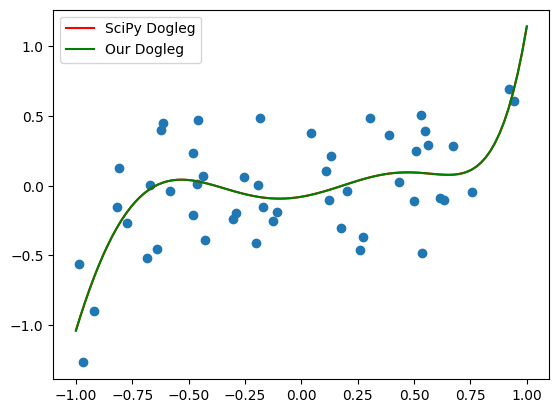

In [ ]:

def test_minimize(method):
    test_case = method.generate_along_ansfunction(beta=method.rsp, m=50, delta=1)
    points = test_case.points
    x, y = [i[0] for i in points], [i[1] for i in points]
    plt.scatter(x, y)

    def fun(a):
        fffffff = method.substitute_beta_to_fbase(a)
        return np.array([fffffff(p[0]) - p[1] for p in points])

    X = np.linspace(-1, 1, 100)
    plt.plot(X, np.vectorize(method.substitute_beta_to_fbase(so.least_squares(fun, test_case.start_point).x))(X), color='r', label='SciPy Dogleg')
    plt.plot(X, np.vectorize(method.substitute_beta_to_fbase(dogleg(test_case.to_sum(), count_grad, test_case.start_point)[-1]))(X), color='g', label='Our Dogleg')
    plt.legend()
    plt.show()

test_minimize(polynomial_test(7, -1, 1))


## Test gradient

In [ ]:

def f(x):
    return x[0] ** 4 + x[1] ** 2


def grad(func, point):
    x = torch.tensor(point, requires_grad=True)
    y = func(x)
    y.backward()
    return x.grad


def grad_simple(func, point, eps=1e-8):
    ret = np.zeros(len(point))
    func_val = func(point)
    for i in range(len(point)):
        point[i] += eps
        ret[i] = (func(point) - func_val)/eps
        point[i] -= eps
    return ret


def grad_advanced(func, point, eps=1e-8):
    ret = np.zeros(len(point))
    for i in range(len(point)):
        point[i] += eps
        ret[i] = func(point)
        point[i] -= 2 * eps
        ret[i] = (ret[i] - func(point))/(2 * eps)
        ret[i] += eps
    return ret


print(grad_simple(f, [1.0, 2.0]))
print(grad_advanced(f, [1.0, 2.0]))
print(grad(f, [1.0, 2.0]))


## Tests with minimize

In [ ]:

def test_minimize_method_scipy(fun, x0, method):
    points = [x0]

    def callback(xk, state=None):
        points.append(xk)
        return True

    so.minimize(fun, x0, method=method, callback=callback)
    return np.array(points)


def test_minimize_method_scipy_dogleg(fun, x0, method, jac, hess):
    points = [x0]

    def callback(xk, state=None):
        points.append(xk)
        return True

    so.minimize(fun, x0, method=method, callback=callback, jac=jac, hess=hess)
    return np.array(points)


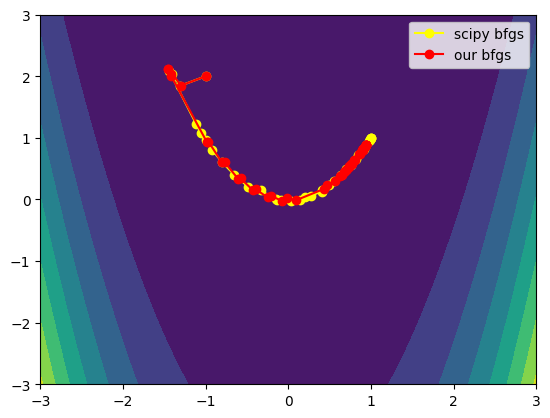

<Figure size 640x480 with 0 Axes>

In [ ]:

rosen = lambda x: (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2

# ---------------- rosen [-1, 2] bfgs ----------------------------------
rosen_x0 = np.array([-1, 2], dtype=float)

points = test_minimize_method_scipy(rosen, rosen_x0, 'BFGS')
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy bfgs')

points = bfgs(rosen, gradient_advanced, rosen_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our bfgs')
plt.legend()

t = np.linspace(-3, 3, 1000)
s = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
plt.show()
plt.clf()


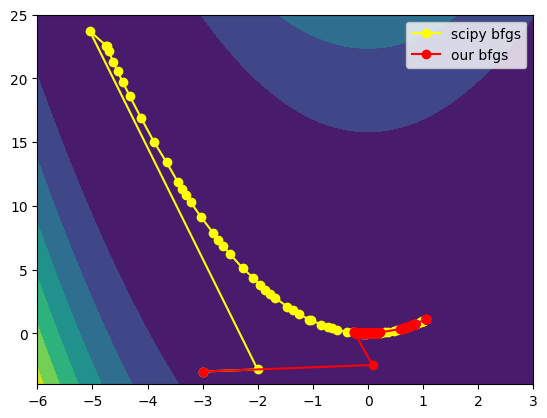

<Figure size 640x480 with 0 Axes>

In [ ]:

# ---------------- rosen [-3, -3] bfgs ----------------------------------
rosen_x0 = np.array([-3, -3], dtype=float)

points = test_minimize_method_scipy(rosen, rosen_x0, 'BFGS')
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy bfgs')

points = bfgs(rosen, gradient_advanced, rosen_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our bfgs')
plt.legend()

t = np.linspace(-6, 3, 1000)
s = np.linspace(-4, 25, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
plt.show()
plt.clf()


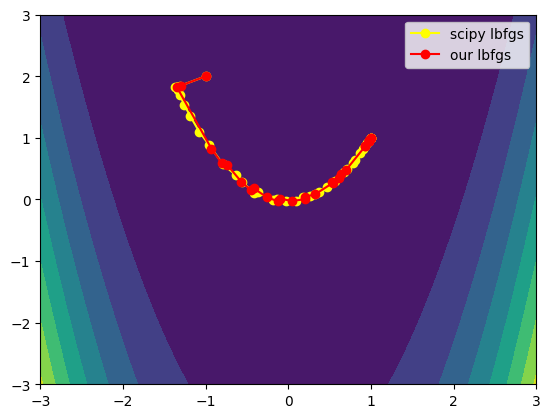

<Figure size 640x480 with 0 Axes>

In [ ]:

# ---------------- rosen [-1, 2] lbfgs ----------------------------------
rosen_x0 = np.array([-1, 2], dtype=float)

points = test_minimize_method_scipy(rosen, rosen_x0, 'L-BFGS-B')
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy lbfgs')

points = lbfgs(rosen, gradient_advanced, rosen_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our lbfgs')
plt.legend()

t = np.linspace(-3, 3, 1000)
s = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
plt.show()
plt.clf()


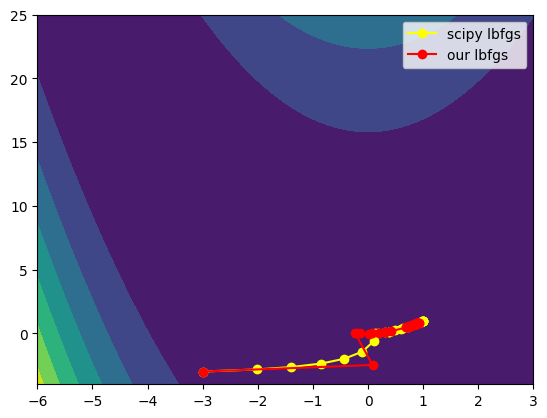

<Figure size 640x480 with 0 Axes>

In [ ]:

# ---------------- rosen [-3, -3] lbfgs ----------------------------------
rosen_x0 = np.array([-3, -3], dtype=float)

points = test_minimize_method_scipy(rosen, rosen_x0, 'L-BFGS-B')
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy lbfgs')

points = lbfgs(rosen, gradient_advanced, rosen_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our lbfgs')
plt.legend()

t = np.linspace(-6, 3, 1000)
s = np.linspace(-4, 25, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
plt.show()
plt.clf()


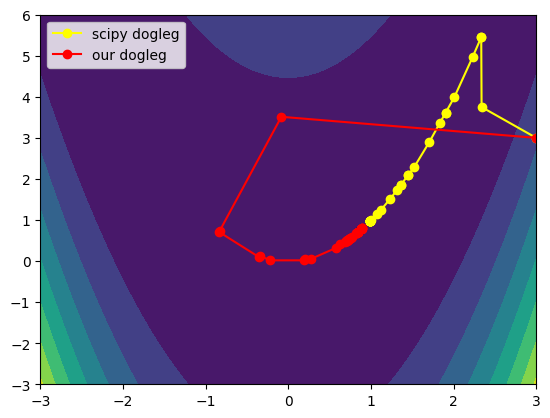

<Figure size 640x480 with 0 Axes>

In [ ]:

# ---------------- rosen [3, 3] dogleg ----------------------------------
rosen_x0 = np.array([3, 3], dtype=float)

points = test_minimize_method_scipy_dogleg(rosen, rosen_x0, 'dogleg', lambda pos: count_grad(rosen, pos),
                                            lambda pos: count_hess(rosen, pos))
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy dogleg')

points = bfgs(rosen, gradient_advanced, rosen_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our dogleg')
plt.legend()

t = np.linspace(-3, 3, 1000)
s = np.linspace(-3, 6, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
plt.show()
plt.clf()


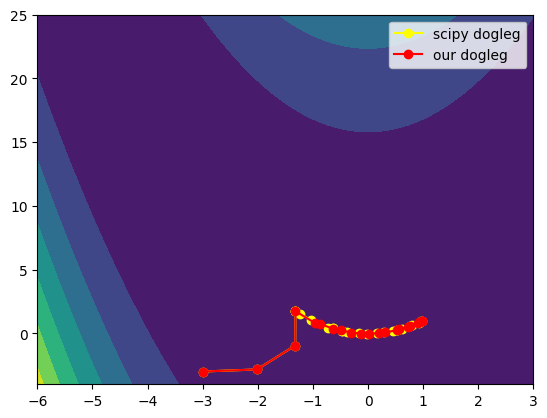

<Figure size 640x480 with 0 Axes>

In [ ]:

# ---------------- rosen [-3, -3] dogleg ----------------------------------
rosen_x0 = np.array([-3, -3], dtype=float)

points = test_minimize_method_scipy_dogleg(rosen, rosen_x0, 'dogleg', lambda pos: count_grad(rosen, pos),
                                            lambda pos: count_hess(rosen, pos))
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy dogleg')

points = dogleg(rosen, gradient_advanced, rosen_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our dogleg')
plt.legend()

t = np.linspace(-6, 3, 1000)

s = np.linspace(-4, 25, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
plt.show()
plt.clf()


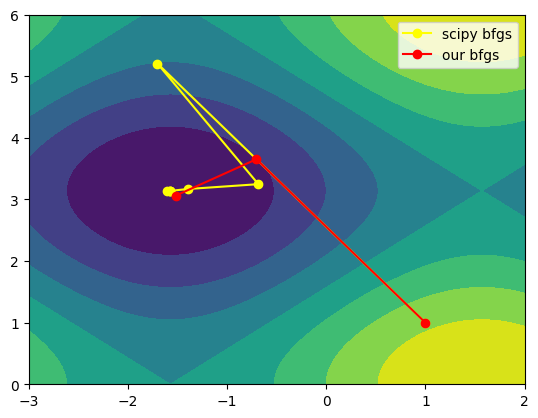

<Figure size 640x480 with 0 Axes>

In [ ]:

sincos = lambda x: np.sin(x[0]) + np.cos(x[1])

# ---------------- sincos [1, 1] bfgs ----------------------------------
sincos_x0 = np.array([1, 1], dtype=float)

points = test_minimize_method_scipy(sincos, sincos_x0, 'BFGS')
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy bfgs')

points = bfgs(sincos, gradient_advanced, sincos_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our bfgs')
plt.legend()

t = np.linspace(-3, 2, 1000)
s = np.linspace(-0, 6, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, sincos([X, Y]))
plt.show()
plt.clf()


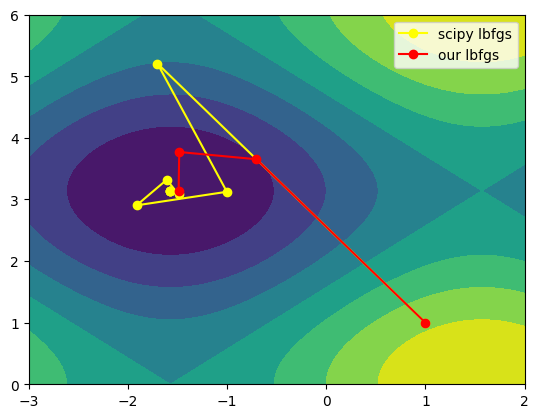

<Figure size 640x480 with 0 Axes>

In [ ]:

# ---------------- sincos [1, 1] lbfgs ----------------------------------
points = test_minimize_method_scipy(sincos, sincos_x0, 'L-BFGS-B')
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy lbfgs')

points = lbfgs(sincos, gradient_advanced, sincos_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our lbfgs')
plt.legend()

t = np.linspace(-3, 2, 1000)
s = np.linspace(-0, 6, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, sincos([X, Y]))
plt.show()
plt.clf()


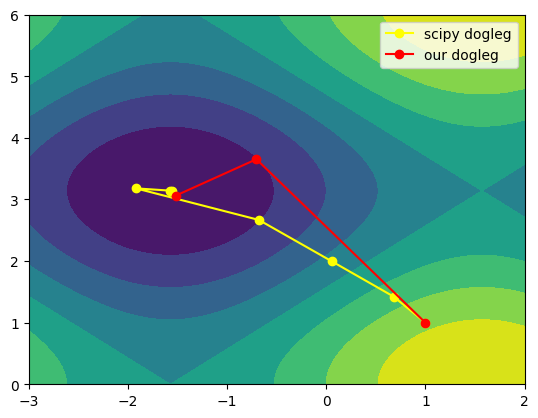

<Figure size 640x480 with 0 Axes>

In [ ]:

# ---------------- sincos [1, 1] dogleg ----------------------------------
sincos_x0 = np.array([1, 1], dtype=float)

points = test_minimize_method_scipy_dogleg(sincos, sincos_x0, 'dogleg', lambda pos: count_grad(sincos, pos),
                                            lambda pos: count_hess(sincos, pos))
plt.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='scipy dogleg')

points = bfgs(sincos, gradient_advanced, sincos_x0)
plt.plot(points[:, 0], points[:, 1], 'o-', color='red', label='our dogleg')
plt.legend()

t = np.linspace(-3, 2, 1000)
s = np.linspace(-0, 6, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, sincos([X, Y]))
plt.show()
plt.clf()


In [ ]:

def test_minimize_method_scipy_bounded(fun, x0, method, x_bound, y_bound):
    points = [x0]

    def callback(xk, state=None):
        points.append(xk)
        return True

    so.minimize(fun, x0, method=method, callback=callback, bounds=(x_bound, y_bound))
    return np.array(points)


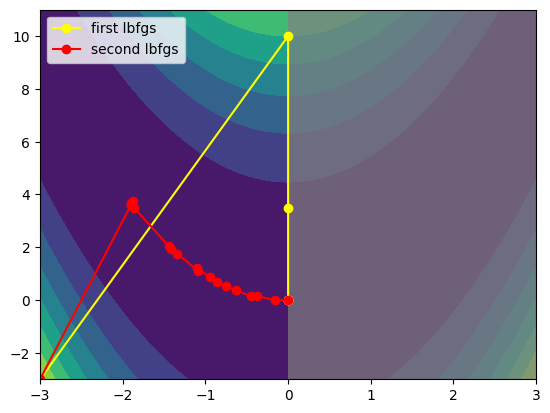

<Figure size 640x480 with 0 Axes>

In [ ]:

rosen_x0 = np.array([-3, -3], dtype=float)

fig, ax = plt.subplots()
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'L-BFGS-B', (-10.0, 0.0), (-10.0, 10.0))
ax.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='first lbfgs')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'L-BFGS-B', (-10.0, 0.0), (0, 10.0))
ax.plot(points[:, 0], points[:, 1], 'o-', color='red', label='second lbfgs')

ax.legend()
t = np.linspace(-3, 3, 1000)
s = np.linspace(-3, 11, 1000)
X, Y = np.meshgrid(t, s)
ax.contourf(X, Y, rosen([X, Y]))
ax.add_patch(Rectangle((0.0, -3), 3, 14,
                            facecolor='gray',
                            fill=True,
                            alpha=0.7,
                            lw=5))
plt.show()
plt.clf()


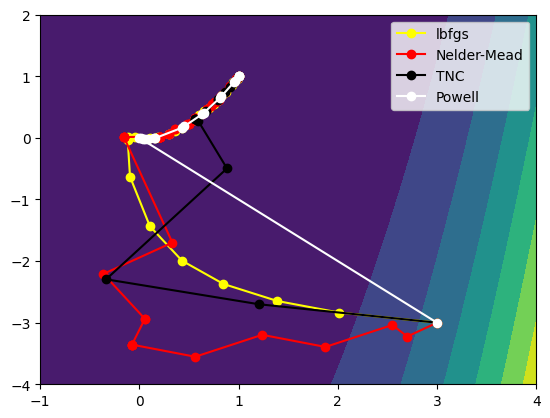

<Figure size 640x480 with 0 Axes>

In [ ]:

rosen_x0 = np.array([3, -3], dtype=float)

x_bound = (None, None)
y_bound = (None, None)
fig, ax = plt.subplots()
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'L-BFGS-B', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='lbfgs')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'Nelder-Mead', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='red', label='Nelder-Mead')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'TNC', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='black', label='TNC')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'Powell', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='white', label='Powell')

plt.legend()

t = np.linspace(-1, 4, 1000)
s = np.linspace(-4, 2, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
plt.show()
plt.clf()


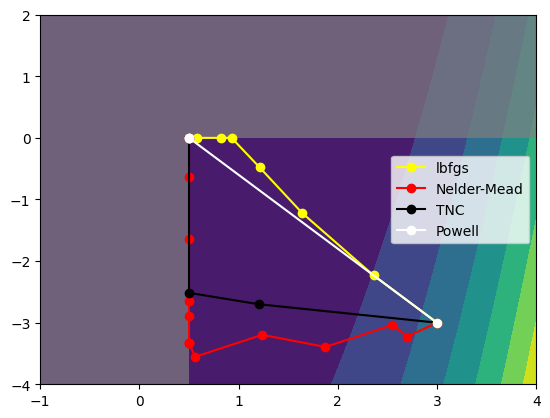

<Figure size 640x480 with 0 Axes>

In [ ]:

x_bound = (0.5, None)
y_bound = (None, 0)
fig, ax = plt.subplots()
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'L-BFGS-B', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='lbfgs')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'Nelder-Mead', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='red', label='Nelder-Mead')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'TNC', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='black', label='TNC')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'Powell', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='white', label='Powell')

plt.legend()

t = np.linspace(-1, 4, 1000)
s = np.linspace(-4, 2, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
ax.add_patch(Rectangle((-1, -4), 1.5, 6,
                           facecolor='gray',
                           fill=True,
                           alpha=0.7,
                           lw=5))
ax.add_patch(Rectangle((0.5, 0), 3.5, 2,
                           facecolor='gray',
                           fill=True,
                           alpha=0.7,
                           lw=5))
plt.show()
plt.clf()


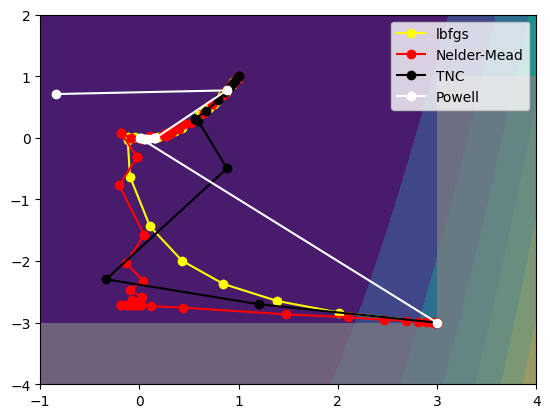

<Figure size 640x480 with 0 Axes>

In [ ]:

x_bound = (None, 3.001)
y_bound = (-3.001, None)
fig, ax = plt.subplots()
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'L-BFGS-B', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='lbfgs')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'Nelder-Mead', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='red', label='Nelder-Mead')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'TNC', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='black', label='TNC')
points = test_minimize_method_scipy_bounded(rosen, rosen_x0, 'Powell', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='white', label='Powell')

plt.legend()

t = np.linspace(-1, 4, 1000)
s = np.linspace(-4, 2, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
ax.add_patch(Rectangle((3, -4), 1, 5,
                           facecolor='gray',
                           fill=True,
                           alpha=0.7,
                           lw=5))
ax.add_patch(Rectangle((-1, -4), 4, 1,
                           facecolor='gray',
                           fill=True,
                           alpha=0.7,
                           lw=5))
plt.show()
plt.clf()


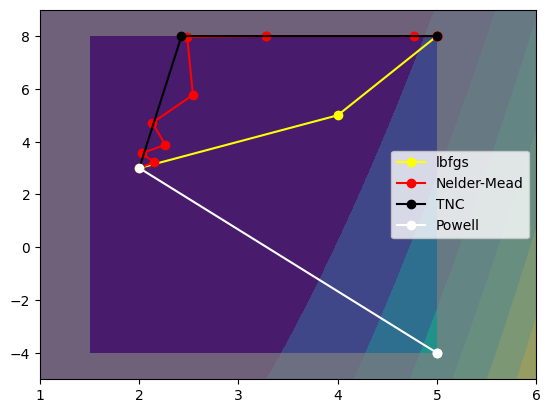

<Figure size 640x480 with 0 Axes>

In [ ]:
fun = lambda x: -(x[0] - 1) ** 2 - (x[1] - 2) ** 2
fun_x0 = np.array([2, 3])
x_bound = (1.5, 5)
y_bound = (-4, 8)
fig, ax = plt.subplots()
points = test_minimize_method_scipy_bounded(fun, fun_x0, 'L-BFGS-B', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='yellow', label='lbfgs')
points = test_minimize_method_scipy_bounded(fun, fun_x0, 'Nelder-Mead', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='red', label='Nelder-Mead')
points = test_minimize_method_scipy_bounded(fun, fun_x0, 'TNC', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='black', label='TNC')
points = test_minimize_method_scipy_bounded(fun, fun_x0, 'Powell', x_bound, y_bound)
ax.plot(points[:, 0], points[:, 1], 'o-', color='white', label='Powell')

plt.legend()

t = np.linspace(1, 6, 1000)
s = np.linspace(-5, 9, 1000)
X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, rosen([X, Y]))
ax.add_patch(Rectangle((1, -5), 5, 1,
                           facecolor='gray',
                           fill=True,
                           alpha=0.7,
                           lw=5))
ax.add_patch(Rectangle((1, -4), 0.5, 13,
                           facecolor='gray',
                           fill=True,
                           alpha=0.7,
                           lw=5))
ax.add_patch(Rectangle((1.5, 8), 4.5, 1,
                           facecolor='gray',
                           fill=True,
                           alpha=0.7,
                           lw=5))
ax.add_patch(Rectangle((5, -4), 1, 12,
                           facecolor='gray',
                           fill=True,
                           alpha=0.7,
                           lw=5))
plt.show()
plt.clf()